#### 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

In [2]:
random_seed = 228
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

#### 2. Load data

Let's load test and train data into separate variables so that the test data does not affect training in any way.

In [4]:
stream_df = pd.read_csv('data/stream_quality_train.csv')
stream_dft = pd.read_csv('data/stream_quality_test.csv')
stream_df.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,packet_loss_rate,packet_loss_std,y
0,0.744824,0.025512,0.786908,0.013918,0.00323,0.0,0.00323,0.066147,0.010390,0.000250,0.000000,1.0
1,0.744824,0.025512,0.810122,0.055803,0.00323,0.0,0.00323,0.077022,0.041797,0.031492,0.153055,1.0
2,0.734408,0.076537,0.791670,0.031781,0.00323,0.0,0.00323,0.069172,0.017070,0.000250,0.000000,1.0
3,0.750031,0.000000,0.826193,0.015573,0.00323,0.0,0.00323,0.061703,0.021221,0.003121,0.014067,1.0
4,0.703162,0.159856,0.816669,0.005438,0.00323,0.0,0.00323,0.040957,0.062898,0.003121,0.014067,1.0


Let's take a look at the data to make sure it's already normalized, doesn't contain categorical features (although this doesn't matter for trees and random forests), and generally doesn't need much preprocessing.

In [6]:
stream_df.describe()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,packet_loss_rate,packet_loss_std,y
count,760552.000000,760552.000000,7.605520e+05,760552.000000,760552.000000,760552.000000,760552.000000,7.605520e+05,760552.000000,760552.000000,760552.000000,760552.000000
mean,0.573862,0.084140,2.319465e-01,0.087737,0.375107,0.013855,0.426036,3.947766e-01,0.113410,0.210568,0.054017,1.194584
std,0.169349,0.071507,1.681769e-01,0.069711,0.471648,0.053630,0.477459,1.828205e-01,0.071459,0.359459,0.086743,0.846783
min,0.000009,0.000000,8.172605e-08,0.000000,0.000002,0.000000,0.000002,1.596526e-08,0.000000,0.000010,0.000000,0.000000
25%,0.480095,0.026579,9.748398e-02,0.029069,0.001744,0.000000,0.002109,2.608380e-01,0.060778,0.000999,0.000000,0.000000
50%,0.561044,0.070193,1.978639e-01,0.072856,0.024770,0.000000,0.049641,4.497636e-01,0.109997,0.041906,0.000000,1.000000
75%,0.673666,0.127213,3.351587e-01,0.133428,1.000000,0.000000,1.000000,5.325386e-01,0.161189,0.143510,0.095150,2.000000
max,1.000000,0.510244,1.000000e+00,0.510244,1.000000,0.510743,1.000000,1.000000e+00,0.503595,1.000000,0.510626,2.000000


In [7]:
stream_dft.describe()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,packet_loss_rate,packet_loss_std,y
count,129978.000000,129978.000000,1.299780e+05,129978.000000,129978.000000,129978.000000,129978.000000,1.299780e+05,129978.000000,129978.000000,129978.000000,129978.000000
mean,0.562242,0.081462,2.193421e-01,0.085001,0.339517,0.015303,0.393941,3.972422e-01,0.112772,0.177990,0.055387,1.217383
std,0.164251,0.070950,1.625906e-01,0.068021,0.460384,0.057180,0.471005,1.813835e-01,0.070860,0.335288,0.087149,0.857186
min,0.000012,0.000000,1.391982e-07,0.000000,0.000003,0.000000,0.000003,1.596526e-08,0.000000,0.000011,0.000000,0.000000
25%,0.477536,0.022696,8.891946e-02,0.028232,0.000999,0.000000,0.000999,2.676697e-01,0.060610,0.000999,0.000000,0.000000
50%,0.550761,0.067979,1.878190e-01,0.070574,0.018182,0.000000,0.037107,4.502050e-01,0.109068,0.031705,0.000000,1.000000
75%,0.658131,0.124792,3.152932e-01,0.128603,1.000000,0.000000,1.000000,5.335235e-01,0.160607,0.106635,0.101940,2.000000
max,1.000000,0.510244,1.000000e+00,0.508469,1.000000,0.510743,1.000000,1.000000e+00,0.441708,1.000000,0.505441,2.000000


Also take a look at the report to see feature correlation and class imbalance.

In [8]:
# from pandas_profiling import ProfileReport
# report = ProfileReport(stream_df)
# report.to_file('data_profile_report.html')

In [9]:
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel, SelectKBest

In [10]:
def generate_pairwise_features(df, select_p = 0.5):

    df = df.copy()

    all_pairs = np.array(list(set(combinations(list(df.columns), 2))))
    mask = np.random.random(len(all_pairs)) < select_p
    selected_pairs = all_pairs[mask]

    for (f, s) in selected_pairs:
        d = dict()

        d[f'{f}_plus_{s}'] = df[f] + df[s]
        d[f'{f}_minus_{s}'] = df[f] - df[s]
        # d[f'{f}_mult_{s}'] = df[f] * df[s]

        new_features = pd.DataFrame(d)
        df = pd.concat([df, new_features], axis=1)

    return df

In [11]:
def generate_math_features(df):
    df = df.copy()

    for c in df.columns:
        d = dict()

        d[c + '_log'] = np.log(df[c].abs() + 1)
        # d[c + '_exp'] = np.exp(df[c])
        d[c + '_sin'] = np.sin(df[c])
        d[c + '_near_q0.5'] = np.abs(df[c] - df[c].quantile(0.5)) < 0.1
        d[c + '_gt_q0.8'] = df[c] > df[c].quantile(0.8)
        # d[c + '_lt_q0.9'] = df[c] < df[c].quantile(0.9)
        # d[c + '_gt_q0.1'] = df[c] > df[c].quantile(0.1)
        d[c + '_lt_q0.2'] = df[c] < df[c].quantile(0.2)

        new_features = pd.DataFrame(d)
        df = pd.concat([df, new_features], axis=1)

    return df

In [12]:
from scipy import stats
stream_df = stream_df[(np.abs(stats.zscore(stream_df)) < 3).all(axis=1)]
# stream_dft = stream_dft[(np.abs(stats.zscore(stream_dft)) < 3).all(axis=1)]

In [13]:
x_train = generate_pairwise_features(stream_df.drop('y', axis=1), select_p=1)
x_train.shape

(698758, 121)

In [14]:
x_test = generate_pairwise_features(stream_dft.drop('y', axis=1), select_p=1)
x_test.shape

(129978, 121)

In [15]:
y_train = stream_df['y']
y_train.shape

(698758,)

In [16]:
y_test = stream_dft['y']
y_test.shape

(129978,)

<AxesSubplot: ylabel='Count'>

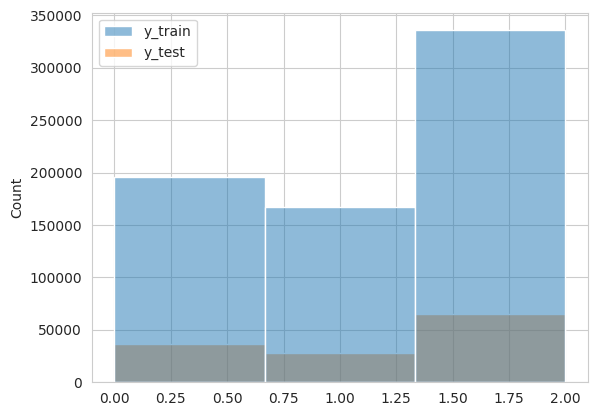

In [17]:
sns.histplot(pd.concat([y_train.rename("y_train"), y_test.rename("y_test")], axis=1), bins=3)

In [18]:
sfm1 = SelectFromModel(threshold="0.3*mean", estimator=RandomForestClassifier(n_estimators=30, random_state=228, n_jobs=12, verbose=1, max_depth=12, class_weight='balanced'), max_features=50)
# sfm1 = SelectKBest(k=30)
sfm1.fit(x_train, y_train)
sfm1.get_feature_names_out().shape

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:   24.5s finished


(41,)

In [19]:
x_train = pd.DataFrame(data=sfm1.transform(x_train), columns=sfm1.get_feature_names_out())
x_train.shape

(698758, 41)

In [20]:
x_test = pd.DataFrame(data=sfm1.transform(x_test), columns=sfm1.get_feature_names_out())
x_test.shape

(129978, 41)

In [21]:
x_train = generate_math_features(x_train)
x_train.shape

(698758, 246)

In [22]:
x_test = generate_math_features(x_test)
x_test.shape

(129978, 246)

In [23]:
sfm2 = SelectFromModel(threshold="0.3*mean", estimator=RandomForestClassifier(n_estimators=30, random_state=228, n_jobs=12, verbose=1, max_depth=12, class_weight='balanced'), max_features=100)
# sfm2 = SelectKBest(k=70)
sfm2.fit(x_train, y_train)
sfm2.get_feature_names_out().shape

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:   23.0s finished


(73,)

In [24]:
x_train = pd.DataFrame(data=sfm2.transform(x_train), columns=sfm2.get_feature_names_out())
x_train.shape

(698758, 73)

In [25]:
x_test = pd.DataFrame(data=sfm2.transform(x_test), columns=sfm2.get_feature_names_out())
x_test.shape

(129978, 73)

In [26]:
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier
from skorch.callbacks import EpochScoring
from skorch.dataset import ValidSplit
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
# fake_x_train = pd.concat([x_train, pd.Series(name='random', data=np.random.randn(x_train.shape[0]))], axis=1)
rf = RandomForestClassifier(n_estimators=32, n_jobs=16, max_depth=10, verbose=1, class_weight='balanced', criterion='gini')
rf.fit(x_train, y_train)
print(classification_report(y_test, rf.predict(x_test)))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81     36695
         1.0       0.81      0.88      0.85     28333
         2.0       0.90      0.85      0.88     64950

    accuracy                           0.85    129978
   macro avg       0.84      0.85      0.84    129978
weighted avg       0.85      0.85      0.85    129978



[Parallel(n_jobs=16)]: Done  32 out of  32 | elapsed:   14.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  32 out of  32 | elapsed:    0.0s finished


In [28]:
pd.DataFrame(zip(rf.feature_names_in_, rf.feature_importances_)).set_index(0).sort_values(by=1, ascending=False)

,1
0,
rtt_mean_minus_dropped_frames_std_log,0.100993
bitrate_mean_sin,0.064202
rtt_mean,0.063982
rtt_mean_sin,0.055933
dropped_frames_std_plus_bitrate_mean,0.053825
...,...
rtt_mean_near_q0.5,0.000512
dropped_frames_std_minus_bitrate_mean_gt_q0.8,0.000469
rtt_mean_plus_dropped_frames_mean,0.000442


In [55]:
# from pytorch_tabnet.tab_model import TabNetClassifier
# tabnet_clf = TabNetClassifier(n_d=8)
# tabnet_clf.fit(x_test.values, y_test.values, max_epochs=12)
# print(classification_report(y_true=y_test, y_pred=tabnet_clf.predict(x_test.values)))

/home/hivaze/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/hivaze/miniconda3/envs/torch/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.50497 |  0:00:04s
epoch 1  | loss: 0.4174  |  0:00:08s
epoch 2  | loss: 0.40783 |  0:00:12s
epoch 3  | loss: 0.40107 |  0:00:15s
epoch 4  | loss: 0.39601 |  0:00:19s
epoch 5  | loss: 0.39473 |  0:00:23s
epoch 6  | loss: 0.3937  |  0:00:27s
epoch 7  | loss: 0.38971 |  0:00:30s
epoch 8  | loss: 0.39038 |  0:00:34s
epoch 9  | loss: 0.38895 |  0:00:38s
epoch 10 | loss: 0.3888  |  0:00:42s
epoch 11 | loss: 0.38732 |  0:00:45s
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80     36695
         1.0       0.84      0.85      0.84     28333
         2.0       0.87      0.90      0.88     64950

    accuracy                           0.85    129978
   macro avg       0.85      0.84      0.84    129978
weighted avg       0.85      0.85      0.85    129978



In [60]:
class SingleClassModel(nn.Module):
    def __init__(self,
                 dropout_p=0.1,
                 n_layers=3,
                 num_of_params=x_train.shape[1],
                 layer_size=15 * x_train.shape[1],
                 n_classes=3
                 ):

        super(SingleClassModel, self).__init__()

        layers = [nn.Sequential(
            nn.BatchNorm1d(num_of_params if i == 0 else layer_size),
            nn.Linear(num_of_params if i == 0 else layer_size, layer_size),
            nn.GELU(),
            nn.Dropout(dropout_p)
        ) for i in range(n_layers)]

        self.network = nn.Sequential(
            *layers,
            nn.BatchNorm1d(layer_size),
            nn.Linear(layer_size, n_classes)
        )

    def forward(self, x):
        return self.network(x)

In [61]:
net = NeuralNetClassifier(
    SingleClassModel,
    max_epochs=200,
    lr=0.005,
    train_split=ValidSplit(cv=5),
    # train_split=None,
    batch_size=1024,
    device='cuda',
    optimizer=torch.optim.AdamW,
    criterion=torch.nn.CrossEntropyLoss,
    callbacks=[EpochScoring(scoring='f1_macro', lower_is_better=False)],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True
)

In [62]:
net.fit(x_train.values.astype(np.float32), y_train.values.astype(np.int64))

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8440        0.4523       0.8581        0.3815  1.0344
      2      0.8491        0.3962       0.8644        0.3669  0.8579
      3      0.8487        0.4008       0.8630        0.3671  0.8650
      4      0.8479        0.3979       0.8632        0.3683  0.8656
      5      0.8497        0.3926       0.8633        0.3729  0.8455
      6      0.8503        0.3936       0.8652        0.3634  0.8474
      7      0.8443        0.3908       0.8607        0.3704  0.8452
      8      0.8472        0.3913       0.8639        0.3739  0.8454
      9      0.8379        0.3905       0.8581        0.3809  0.8511
     10      0.8485        0.3869       0.8626        0.3742  0.8604
     11      0.8475        0.3839       0.8640        0.3679  1.1319
     12      0.8483        0.3862       0.8651        0.3643  0.8474
     13      0.8476        0.3838 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SingleClassModel(
    (network): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(73, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=73, out_features=1095, bias=True)
        (2): GELU(approximate=none)
        (3): Dropout(p=0.0, inplace=False)
      )
      (1): Sequential(
        (0): BatchNorm1d(1095, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=1095, out_features=1095, bias=True)
        (2): GELU(approximate=none)
        (3): Dropout(p=0.0, inplace=False)
      )
      (2): Sequential(
        (0): BatchNorm1d(1095, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=1095, out_features=1095, bias=True)
        (2): GELU(approximate=none)
        (3): Dropout(p=0.0, inplace=False)
      )
      (3): BatchNorm1d(1095, eps=1e-05, momentum=0.1, affine=True, t

In [63]:
print(classification_report(y_true=y_test, y_pred=net.predict(x_test.values.astype(np.float32))))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90     36695
         1.0       0.93      0.92      0.93     28333
         2.0       0.95      0.93      0.94     64950

    accuracy                           0.93    129978
   macro avg       0.92      0.92      0.92    129978
weighted avg       0.93      0.93      0.93    129978



In [64]:
print(classification_report(y_true=y_train, y_pred=net.predict(x_train.values.astype(np.float32))))

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77    195754
         1.0       0.83      0.81      0.82    167126
         2.0       0.86      0.85      0.85    335878

    accuracy                           0.82    698758
   macro avg       0.81      0.81      0.81    698758
weighted avg       0.82      0.82      0.82    698758



In [41]:
bc = BaggingClassifier(base_estimator=net, n_estimators=5, max_samples=0.5, n_jobs=1)
bc.fit(x_train.values.astype(np.float32), y_train.values.astype(np.float32))
print(classification_report(y_true=y_test, y_pred=bc.predict(x_test.values.astype(np.float32))))

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8279        0.3954       0.8386        0.4023  1.8357
      2      0.8406        0.3802       0.8494        0.3834  1.5916
      3      0.8487        0.3791       0.8549        0.3840  1.6521
      4      0.8491        0.3786       0.8545        0.3845  1.5498
      5      0.8476        0.3777       0.8534        0.3821  1.6076
      6      0.8488        0.3757       0.8556        0.3741  1.5657
      7      0.8479        0.3758       0.8550        0.3881  1.6223
  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8417        0.3940       0.8481        0.3989  1.7882
      2      0.8484        0.3819       0.8551        0.3805  1.6438
      3      0.8491        0.3784       0.8548        0.3752  1.5659
      4      0.8495        0.3780 

In [35]:
sc = StackingClassifier(estimators=[('model_1', net), ('model_2', net), ('model_3', net), ('model_4', net), ('model_5', net)],
                        n_jobs=1, final_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'))
sc.fit(x_train.values.astype(np.float32), y_train.values.astype(np.float32))
print(classification_report(y_true=y_test, y_pred=sc.predict(x_test.values.astype(np.float32))))

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8501        0.3865       0.8580        0.3785  4.0644
      2      0.8504        0.3787       0.8585        0.3674  3.8430
      3      0.8494        0.3764       0.8578        0.3705  3.8482
      4      0.8525        0.3760       0.8599        0.3692  3.8354
      5      0.8524        0.3747       0.8606        0.3681  3.8521
  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8501        0.3870       0.8585        0.3694  3.8308
      2      0.8512        0.3784       0.8596        0.3703  3.8509
      3      0.8518        0.3772       0.8599        0.3702  3.8947
      4      0.8529        0.3758       0.8605        0.3686  3.7782
      5      0.8522        0.3753       0.8602        0.3664  3.8404
  epoch    f1_macro    train_loss 

In [34]:
vc = VotingClassifier([('model_1', net), ('model_2', net), ('model_3', net), ('model_4', net), ('model_5', net)])
vc.fit(x_train.values.astype(np.float32), y_train.values.astype(np.float32))
print(classification_report(y_true=y_test, y_pred=vc.predict(x_test.values.astype(np.float32))))

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8466        0.3860       0.8529        0.3758  4.3343
      2      0.8528        0.3784       0.8600        0.3697  3.8582
      3      0.8513        0.3768       0.8592        0.3680  3.7865
      4      0.8515        0.3761       0.8590        0.3672  3.8389
      5      0.8523        0.3746       0.8604        0.3662  3.8969
  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.8513        0.3868       0.8590        0.3714  3.8650
      2      0.8448        0.3786       0.8533        0.3746  3.9192
      3      0.8517        0.3770       0.8599        0.3669  3.8662
      4      0.8507        0.3755       0.8578        0.3685  4.1609
      5      0.8515        0.3748       0.8598        0.3671  3.9118
  epoch    f1_macro    train_loss 